In [1]:
import seaborn as sns

import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/home/sanj/projects/IR/rna-seq-busia/workflow/scripts/')
import rnaseqpoptools as rnaseqpop
import pandas as pd
import numpy as np
import allel
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
metadata = pd.read_csv("../../config/samples.tsv", sep="\t")
ploidy = 10
numbers = rnaseqpop.get_numbers_dict(ploidy)

### Load the genotype data without filters

In [3]:
vcf, geno, ac_subpops, pos, depth, snpeff, subpops, samplenames = rnaseqpop.readAndFilterVcf("../../results/variantAnalysis/vcfs/Ag_Busia.2L.vcf.gz", 
                                                                                             chrom='2L', 
                                                                                             samples=metadata, 
                                                                                             numbers=numbers, 
                                                                                             ploidy=ploidy, 
                                                                                             qualflt=0, 
                                                                                             missingfltprop=0)


-------------- Reading VCF for chromosome 2L --------------
------- Filtering VCF at QUAL=0 and missingness proportion of 0 -------
QUAL filter will retain 396426 SNPs retained out of 396426 for chromosome 2L
Missingness filter will retain 396426 SNPs out of 396426 for chromosome 2L
The combined filter will retain 396426 SNPs out of 396426 for chromosome 2L


In [4]:
ac = geno.count_alleles()
snpcounts = ac.sum(axis=1)

In [5]:
missingfltprop  = 1

missingflt = snpcounts.max()*missingfltprop # must have at least 1/p alleles present
missingness_flt = snpcounts >= missingflt

Lets look at the distribution of called alleles across samples

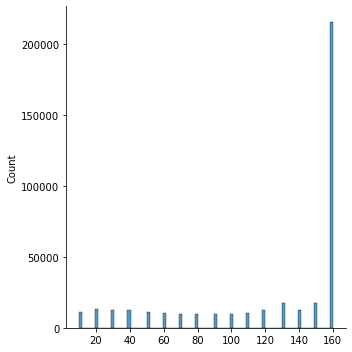

In [6]:
sns.displot(snpcounts)

What about the median depth at only 10 alleles called, vs 160 (the max in Busia dataset (16 reps * 10 ploidy) alleles called. 

In [7]:
data = depth[snpcounts <= 10]
print("median:", np.median(data))
pd.Series(data).describe()

median: 2.0


count    11336.000000
mean         2.204658
std          1.491431
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max        117.000000
dtype: float64

So we do have some alleles being called with only one supporting read, with a median of 2. There is only 11,000 of these SNPs, out of ~350,000.

These would of course be completely removed when using a moderate-high missingness filter.

In [8]:
data = depth[snpcounts == 160]
print("median:", np.median(data))
pd.Series(data).describe()

median: 704.0


count    215513.000000
mean       1765.391619
std        5750.028490
min          27.000000
25%         337.000000
50%         704.000000
75%        1577.000000
max      298793.000000
dtype: float64

So if we use a missingness filter of 1, as I have been, the median number of reads that cover a site is then 704.

In [9]:
meds = {}
lows = {}
mins = {}
highs = {}
maxs = {}

for snpc in np.arange(10,160,10):
    data = depth[snpcounts == snpc]
    print("median:", np.median(data))
    meds[snpc] = np.median(data)
    lows[snpc] = np.percentile(data, 10)
    highs[snpc] = np.percentile(data, 90)
    mins[snpc] = np.min(data)
    maxs[snpc] = np.max(data)

median: 2.0
median: 3.0
median: 5.0
median: 6.0
median: 8.0
median: 10.0
median: 12.0
median: 15.0
median: 19.0
median: 24.0
median: 30.0
median: 42.0
median: 86.0
median: 63.0
median: 92.0


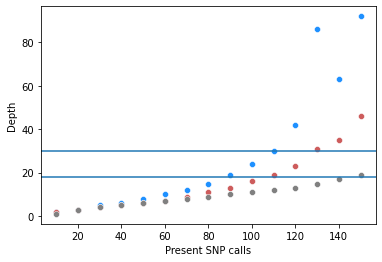

In [10]:
fig, ax = plt.subplots(1,1)
sns.scatterplot(x=meds.keys(), y=meds.values(), color='dodgerblue')
sns.scatterplot(x=meds.keys(), y=lows.values(), color='indianred')
#sns.scatterplot(x=meds.keys(), y=highs.values(), color='green')
#sns.scatterplot(x=meds.keys(), y=maxs.values(), color='gold')
sns.scatterplot(x=meds.keys(), y=mins.values(), color='grey')
ax.set_ylabel("Depth")
ax.set_xlabel("Present SNP calls")
ax.axhline(18)
ax.axhline(30)

### Heterozygosity V depth

In [19]:
allel.heterozygosity_expected(ac.to_frequencies(), ploidy=2)

array([0.        , 0.11917355, 0.22960938, ..., 0.32      , 0.5       ,
       0.455     ])

In [13]:
het = allel.heterozygosity_observed(geno)

In [44]:
?np.arange

In [72]:
dps, size = np.linspace(0, depth.max(), 100, retstep=True)

In [73]:
meds = {}
lows = {}
mins = {}
highs = {}
maxs = {}

for dp in dps[:-1]:
    
    data = het[(depth > dp) & (depth < dp+size)]
    if len(data) < 1:
        continue
    print(dp, "mean:", np.mean(data))
    meds[dp] = np.mean(data)
    lows[dp] = np.percentile(data, 10)
    highs[dp] = np.percentile(data, 90)
    mins[dp] = np.min(data)
    maxs[dp] = np.max(data)

0.0 mean: 0.2036412470288013
3018.1111111111113 mean: 0.38986282489485746
6036.222222222223 mean: 0.3868282437488197
9054.333333333334 mean: 0.38151758282211073
12072.444444444445 mean: 0.3909769667771607
15090.555555555557 mean: 0.4015603085553997
18108.666666666668 mean: 0.40244309119907207
21126.77777777778 mean: 0.41242283950617287
24144.88888888889 mean: 0.3893280632411067
27163.0 mean: 0.4316860465116279
30181.111111111113 mean: 0.3845766129032258
33199.222222222226 mean: 0.41443781314470973
36217.333333333336 mean: 0.3775
39235.444444444445 mean: 0.39950980392156865
42253.55555555556 mean: 0.36975931677018636
45271.66666666667 mean: 0.4032258064516129
48289.77777777778 mean: 0.3286290322580645
51307.88888888889 mean: 0.4725
54326.0 mean: 0.3971774193548387
57344.11111111112 mean: 0.368452380952381
60362.222222222226 mean: 0.4097222222222222
63380.333333333336 mean: 0.43125
66398.44444444445 mean: 0.34765625
69416.55555555556 mean: 0.3392857142857143
72434.66666666667 mean: 0.470

Text(0.5, 0, 'depth')

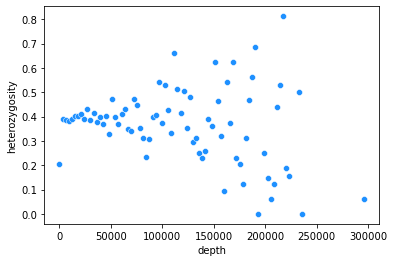

In [74]:
fig, ax = plt.subplots(1,1)
sns.scatterplot(x=meds.keys(), y=meds.values(), color='dodgerblue')
ax.set_ylabel("heterozygosity")
ax.set_xlabel("depth")

In [86]:
df = pd.DataFrame({"depth":depth, "het":het})
df['bins'] = pd.qcut(depth, q=10)

<AxesSubplot:xlabel='bins'>

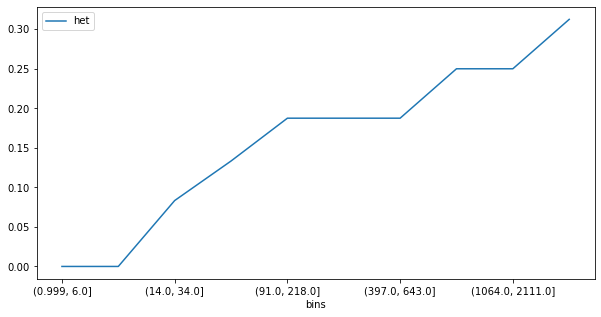

In [98]:
fig,ax = plt.subplots(1,1, figsize=[10,5])
df.groupby('bins').agg({'het':'median'}).plot(ax=ax)

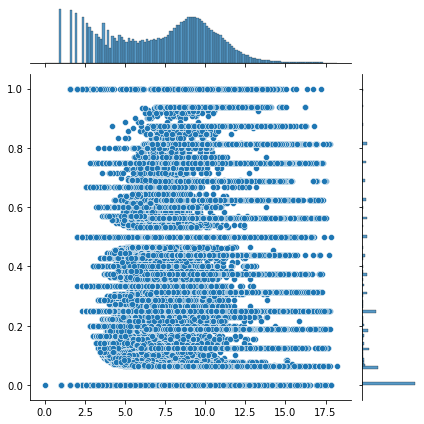

In [38]:
sns.jointplot(x=np.log2(depth), y=het)

In [129]:
gff3 = allel.gff3_to_dataframe("../../resources/reference/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.12.gff3", attributes=['ID', 'Parent'])

In [130]:
exons = gff3.query("type == 'exon' & seqid == '2L'")

In [136]:
lower_range = exons['start'] - 5
upper_range = exons['start'] + 5